In [19]:
# ROOT
import ROOT
from root_numpy import root2array, tree2array, root2rec, testdata
import glob

# PANDAS & NUMPY
import numpy as np
import pandas as pd

# MATPLOTLIB
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as mpatches

# SCIPY
from scipy.optimize import minimize # MINIMIZATION

# OTHER
import copy

## Prepare data structure and functions for single tracking

### Line

In [2]:
class Line:
    def __init__(self, x=0, y=0, z=0, dx=0, dy=0, dz=0, point=[], direction=[], params=[], det_id=0):
        if len(params) == 6:
            self.x,  self.y,  self.z  = params[:3] 
            self.dx, self.dy, self.dz = params[3:]
        elif len(point) == 3 and len(direction) == 3:
            self.x,  self.y,  self.z  = point
            self.dx, self.dy, self.dz = direction
        else:
            self.x,  self.y,  self.z  =  x,  y,  z
            self.dx, self.dy, self.dz = dx, dy, dz
        
        # just to make this line a detector Line
        self.det_id = int(det_id)

    def __repr__(self):
        return "Line: det = {}\t p = ({:.3f}, {:.3f}, {:.3f})\t v = [{:.3f}, {:.3f}, {:.3f}]".format(
            self.det_id, self.x, self.y, self.z, self.dx, self.dy, self.dz
        )
            
    def distance(self, other):
        n_vector = np.cross(self.line_vector(), other.line_vector())
        s_o_vector = np.array([self.x - other.x, self.y - other.y, self.z - other.z])
        return np.linalg.norm( np.dot(n_vector, s_o_vector) ) / np.linalg.norm(n_vector)

    def line_vector(self):
        return np.array([self.dx, self.dy, self.dz])

### Open root file

In [3]:
geometry_root = root2array('det_geometry.root', 'T')
reco_flat = root2array('reco_10k_flat.root', 'T')

### Prepare dataframes

In [4]:
geom_df = pd.DataFrame(geometry_root) 
df_all  = pd.DataFrame(reco_flat)

single_df = df_all.loc[(df_all['uLineSize'] == 1) & (df_all['vLineSize'] == 1)]     # OLNY RPS WITH SINGLE TRACKING
single_groups_df = single_df[['eventID', 'groupID', 'rpID']]\
    .drop_duplicates()\
    .groupby(['eventID', 'groupID'])\
    .size()\
    .reset_index(name='counts')
single_groups_df = single_groups_df.loc[(single_groups_df['counts'] == 3)]          # ONLY HITS WHERE ALL RPS 
                                                                                    # FROM GROUP WAS HIT

print("all tracks shape: {}".format(df_all.shape))
print("single tracking shape: {}".format(single_df.shape))
print("single_groups shape: {}".format(single_groups_df.shape))

all tracks shape: (569625, 10)
single tracking shape: (502443, 10)
single_groups shape: (15320, 3)


# CLASSES FOR RP_SILICON PLOTTING

### BASIC CLASSES

In [5]:
class Direction:
    '''
    Wektor jednostkowy
    '''
    def __init__(self, dx=1.0, dy=0.0):
        self.dx = dx
        self.dy = dy
    
    def __repr__(self):
        return "dx = {}\tdy={}".format(self.dx, self.dy)

    def get_perpendicular(self):
        return Direction(self.dy, -self.dx)
        
    
class Vector2D:
    def __init__(self, x=0.0, y=0.0, start=None, end=None):
        if start is None or end is None:
            self.x = x
            self.y = y
        else:
            self.x = end.x - start.x
            self.y = end.y - start.y
                 
    def __repr__(self):
        return "x = {}\ty = {}".format(self.x, self.y)
    
    def as_arr(self):
        return np.array([self.x, self.y])
    
    def dot(self, other):
        return np.dot(self.as_arr(), other.as_arr())
    

class Point2D:
    def __init__(self, x=0.0, y=0.0):
        self.x = x
        self.y = y
    
    def __repr__(self):
        return "x = {}\ty = {}".format(self.x, self.y)
    
    def move(self, vector):
        self.x += vector.x
        self.y += vector.y
    
    def rotate_around_point(self, other, direction):
        s = direction.dy
        c = direction.dx
        
        new_x = c * (self.x - other.x) - s * (self.y - other.y) + other.x
        new_y = s * (self.x - other.x) + c * (self.y - other.y) + other.y
    
        self.x = new_x
        self.y = new_y

### Geometry inclusion tests

In [48]:
# by: https://stackoverflow.com/questions/2752725/finding-whether-a-point-lies-inside-a-rectangle-or-not/2763387#2763387
def inside_rect(rect_points, P):
    '''
    rect_points - consequtive points of rectangle - can be clockwise and counter clockwise
    P           - tested point (Point2D class)
    
     A ___________D
      |          |
      |          |
      |__________|
     B           C
    
    (0 < AP â‹… AB < AB â‹… AB) and (0 < AP â‹… AD < AD â‹… AD)
    ''' 
    A, B, C, D = rect_points
    
    AB = Vector2D(start=A, end=B)
    AD = Vector2D(start=A, end=D)
    AP = Vector2D(start=A, end=P)
    
    return  0.0 < AB.dot(AP) and \
            AB.dot(AP) < AB.dot(AB) and \
            0.0 < AD.dot(AP) and \
            AD.dot(AP) < AD.dot(AD)

# by: https://www.gamedev.net/forums/topic/295943-is-this-a-better-point-in-triangle-test-2d/?tab=comments#comment-2873873
def inside_triangle(triangle_points, P):
    '''
    triangle_points - consequtive points of triangle - can be clockwise and counter clockwise
    P               - tested point (Point2D class)
    '''
    A, B, C = triangle_points

    b0 = Vector2D(P.x - A.x, P.y - A.y).dot(Vector2D(A.y - B.y, B.x - A.x)) > 0.0
    b1 = Vector2D(P.x - B.x, P.y - B.y).dot(Vector2D(B.y - C.y, C.x - B.x)) > 0.0
    b2 = Vector2D(P.x - C.x, P.y - C.y).dot(Vector2D(C.y - A.y, A.x - C.x)) > 0.0
    
#     print("b0 = {}\tb1 = {}\tb2 = {}\t".format(b0, b1, b2))
    
    return b0 == b1 and b1 == b2

### RPSilicon class.
    Apply fiducials to detector: 
    
    Fiducial center is moved by [dx, dy] wrt RPSilicon.center.
    [dx, dy] defined in Geometry/TotemRPData/data/RP_Hybrid.xml as
        - RP_Det_dx_0
        - RP_Det_dy_0

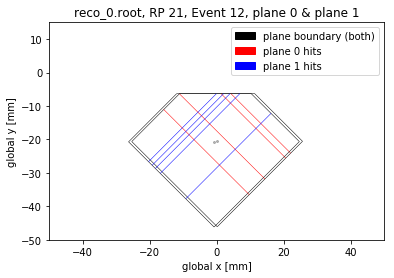

In [38]:

class RPSilicon:
    a = 36.07  # side length [mm]
    e = 22.276 # edge length [mm]

    d_T =  Point2D(  a/2.0,                 a/2.0                ) # T
    d_L =  Point2D( -a/2.0,                 a/2.0                ) # L
    d_R =  Point2D(  a/2.0,                -a/2.0                ) # R
    d_EL = Point2D( -a/2.0,                -a/2.0 + e/np.sqrt(2) ) # EL
    d_ER = Point2D( -a/2.0 + e/np.sqrt(2), -a/2.0                ) # ER
    
    RP_Det_Fid_Top_a   = 0.301  # [mm]
    RP_Det_Fid_Top_b   = 1.0275 # [mm]
    RP_Det_Fid_Left_a  = 0.301  # [mm]
    RP_Det_Fid_Left_c  = 0.2985 # [mm]
    RP_Det_Fid_Right_b = 1.0275 # [mm]
    RP_Det_Fid_Right_d = 1.0255 # [mm]

    RP_Det_dx_0 = ( RP_Det_Fid_Left_c  -  RP_Det_Fid_Right_b) / 2.0 # [mm]
    RP_Det_dy_0 = ( RP_Det_Fid_Right_d  -  RP_Det_Fid_Left_a) / 2.0 # [mm]

    
    def __init__(self, center, direction, siId, T = d_T, L = d_L, R = d_R, EL = d_EL, ER = d_ER):
        self.center = center
        self.direction = direction
        self.siId = siId
        
        self.T = copy.deepcopy(T)
        self.L = copy.deepcopy(L)
        self.R = copy.deepcopy(R)
        self.EL = copy.deepcopy(EL)
        self.ER = copy.deepcopy(ER)
        self.points = [self.R, self.T, self.L, self.EL, self.ER] # In sequence
        
        # FIDUCIAL
        self.fid_center = copy.deepcopy(self.center)
        self.fid_center.move(Vector2D(RPSilicon.RP_Det_dx_0, RPSilicon.RP_Det_dy_0))
        self.fid_center.rotate_around_point(self.center, self.get_rot_direction())

        # MOVE DETECTOR POINTS
        self.move(Vector2D(self.center.x, self.center.y))    # general position
        
        # ROTATE AROUND CENTER
        rot_direction = self.get_rot_direction()
        self.rotate_around_center(rot_direction)
          
    
    def get_rot_direction(self):
        arm = int(self.siId / 1000)
        if arm == 0 and self.siId % 2 == 0:
            return self.direction
        elif arm == 0 and self.siId % 2 == 1:
            return Direction(self.direction.dy, -self.direction.dx)
        elif arm == 1 and self.siId % 2 == 0:
            return Direction(self.direction.dy, -self.direction.dx)
        else:
            return self.direction

    def contains(self, P):
        ''' check if detector plane contains point P'''
        det_square_points           = self.get_det_square_points()
        det_missing_triangle_points = self.get_missing_triangle_points()
            
        return inside_rect(det_square_points, P) and not inside_triangle(det_missing_triangle_points, P)
    
    def get_det_square_points(self):
        TL = Vector2D(start = self.T, end = self.L)
        r_B = copy.deepcopy(self.R)   #BOTTOM point
        r_B.move(TL)
        
        r_T = copy.deepcopy(self.T)
        r_L = copy.deepcopy(self.L)
        r_R = copy.deepcopy(self.R)
        
        return np.array([r_T, r_L, r_B, r_R]) # TOP, LEFT, BOTTOM, RIGHT
    
    def get_missing_triangle_points(self):
        TL = Vector2D(start = self.T, end = self.L)
        r_B = copy.deepcopy(self.R)   #BOTTOM point
        r_B.move(TL)
        
        r_EL = copy.deepcopy(self.EL)
        r_ER = copy.deepcopy(self.ER)
        
        return np.array([r_B, r_EL, r_ER])
        
    def __repr__(self):
        return "T = {} \nL = {} \nR = {} \nEL = {}\nER = {}".format(self.T, self.L, self.R, self.EL, self.ER)

    def move(self, vector):
        for p in self.points:
            p.move(vector)
    
    def rotate_around_center(self, direction):
        for p in self.points:
            p.rotate_around_point(self.center, direction)
    
    def add_to_plot(self, ax, distances, rp_color=[0,0,0,1], hit_color=[1,0,0,1]):
        np_points = np.append(self.points, self.points[0])
        
        # PLOTTING SILICON DETECTOR
        x = np.array([p.x for p in np_points])
        y = np.array([p.y for p in np_points])
        
        starts = [ [x[i], y[i]] for i in range(len(x)-1)]
        ends = [ [x[i+1], y[i+1]] for i in range(len(y)-1)]
        rp_segments = np.array(list(zip(starts,ends)))
        rp_colors = np.full((len(self.points), 4), rp_color) 
         
        rp_line_segments = LineCollection(rp_segments, colors=rp_colors, linewidths=0.5)    
        ax.add_collection(rp_line_segments)
        
        # PLOTTING CENTER POINT
        c_x = [self.center.x]
        c_y = [self.center.y]
        
        ax.plot(c_x, c_y, 'ok', markersize=2, alpha=0.25)
        
        # PLOTTING HIT LINES
        hit_segments = [HitSegment(d, self).get_segment() for d in distances]
        hit_colors = np.full((len(distances), 4), hit_color)

        hit_lines = LineCollection(hit_segments, colors=hit_colors, linewidths=0.5)
        ax.add_collection(hit_lines)
    
class HitSegment:
    def __init__(self, distance, rp_silicon):
        self.distance = distance
        self.rp_silicon = rp_silicon

    def get_start_vector_fraction(self):
        safe_dist_lower_bound = -RPSilicon.a / 2.0 + RPSilicon.e/np.sqrt(2) # how low position can be not to touch the edge of silicon
        if self.distance >= safe_dist_lower_bound: # hit segment does not touch the silicon edge
            return 0.5
        
        start_segment_length = RPSilicon.a / 2.0 - (safe_dist_lower_bound - self.distance)
        start_segment_fraction = start_segment_length / (RPSilicon.a / 2.0)
        return 0.5 * start_segment_fraction                   
    
    
    def get_hit_segment_vector(self):
        siId = self.rp_silicon.siId
        arm = int(siId / 1000)
        
        vector_RT = Vector2D(start=self.rp_silicon.R, end=self.rp_silicon.T)
        vector_LT = Vector2D(start=self.rp_silicon.L, end=self.rp_silicon.T)
        
        if   arm == 0 and siId % 2 == 0:  
            return vector_RT
        elif arm == 0 and siId % 2 == 1:
            return vector_LT
        elif arm == 1 and siId % 2 == 0:
            return vector_LT
        else:
            return vector_RT
    
    def get_segment(self):
        c_projection = Point2D()
        c_projection.x = self.rp_silicon.center.x + self.distance * self.rp_silicon.direction.dx
        c_projection.y = self.rp_silicon.center.y + self.distance * self.rp_silicon.direction.dy
  
        v = self.get_hit_segment_vector()
    
        vector_k = self.get_start_vector_fraction()
        seg_start = Point2D(c_projection.x - vector_k * v.x, c_projection.y - vector_k * v.y)
        seg_end = Point2D(c_projection.x + 0.5 * v.x, c_projection.y + 0.5 * v.y)
        
        return [(seg_start.x, seg_start.y), (seg_end.x, seg_end.y)]

fig, ax = plt.subplots()
       
si_0 = RPSilicon(Point2D(0.163, -20.594), Direction(-0.706, -0.708), 210)
si_0_distances = [-13.0205, -10.9415, -2.1305, 4.5025]
si_0.add_to_plot(ax, si_0_distances, rp_color=[0, 0, 0, 1], hit_color=[1, 0, 0, 1])

si_1 = RPSilicon(Point2D(-0.788, -20.678), Direction(0.708, -0.706), 211)
si_1_distances = [-9.6215, -8.1035, -6.7505, -4.6715, 6.0865]
si_1.add_to_plot(ax, si_1_distances, rp_color=[0, 0, 0, 1], hit_color=[0, 0, 1, 1])

plt.axis('equal')
plt.axis([-50, 50, -50, 15])
plt.ylabel('global y [mm]')
plt.xlabel('global x [mm]')
ax.set_title('reco_0.root, RP 21, Event 12, plane 0 & plane 1')

rp_patch = mpatches.Patch(color='black', label='plane boundary (both)')
si_0_patch = mpatches.Patch(color='red', label='plane 0 hits')
si_1_patch = mpatches.Patch(color='blue', label='plane 1 hits')
plt.legend(handles=[rp_patch, si_0_patch, si_1_patch])


# p_y = [-34.77415, -34.7783, -34.7959, -34.80915,
#      -32.6277, -32.63185, -32.64945, -32.6627,
#      -30.71456, -30.71872, -30.73631, -30.74956,
#      -27.77486, -27.77902, -27.79661, -27.80986,
#      -12.56308, -12.56723, -12.58483, -12.59808]

# p_x = [-0.2760171, -0.2718532, -0.2542063, -0.2409216,
#      -0.2790488, -0.2748849, -0.257238, -0.2439533,
#      -0.281751, -0.2775871, -0.2599402, -0.2466555,
#      -0.2859031, -0.2817392, -0.2640923, -0.2508076,
#      -0.3073886, -0.3032247, -0.2855778, -0.2722931]

# plt.scatter(p_x, p_y)

plt.show()

### Create hit lines for given hits dataframe

In [11]:
DET_Z_TRANSLATION = 0 # SET WITHIN EVENT PROCESSING


def get_hit_lines(single_hits_df, geom_df):
    '''
        reco_0_flat.root:     recoID  eventID  armID  groupID  rpID  uLineSize  vLineSize  siliconID   position  sigma_
        det_geometry.root:    detId   x        y      z        dx    dy
    '''
    
    hit_lines = []

    for h_index, h_row in single_hits_df.iterrows():
        
        h_position = h_row['position']
        det_ID = 10 * h_row['rpID'] + h_row['siliconID']        
        det_info = geom_df.loc[(geom_df['detId'] == det_ID)].iloc[0]
    
        rp_silicon = RPSilicon(Point2D(det_info['x'], det_info['y']), Direction(dx=det_info['dx'], dy=det_info['dy']), det_ID)
        
        x = rp_silicon.fid_center.x + h_position * det_info['dx']    # was: det_info['x'], but now: fiducial included [mm]
        y = rp_silicon.fid_center.y + h_position * det_info['dy']    # was: det_info['y'], but now: fiducial included [mm] 
        
        z = det_info['z'] * 1000 + DET_Z_TRANSLATION     # z [mm] with translation to operate on smaller numbers
        dx = - det_info['dy']  
        dy = det_info['dx'] 
        dz = 0
        
        new_line = Line(x, y, z, dx, dy, dz, det_id=det_ID)
        hit_lines.append(new_line)
        
    return hit_lines

### Printing fitting solution

In [12]:
class Hit:
    def __init__(self, x=0, y=0, z=0):
        self.x = x
        self.y = y
        self.z = z


def print_pretty_solution(solution, geom_df):
    print("FULL SOLUTION: \n{}".format(solution))
    print("Sum of distances: {}".format(solution.fun))
    print("Solution: [\n\tx = {}\n\ty = {} \n\tz = {} \n\tdx = {} \n\tdy = {} \n\tdz = {} ]".format(
        solution.x[0],
        solution.x[1],
        solution.x[2], # - DET_Z_TRANSLATION,
        solution.x[3],
        solution.x[4],
        solution.x[5])
    )
    print("]")
    print("\nDistances from detector lines and hit position")
    print("ID\tDistance from hit line [mm]\t x [mm]\t\ty [mm]\t\tz [m]")

    plane_hit = Hit()

    for line in LINE_SET:
        sol_x, sol_y, sol_z = solution.x[0], solution.x[1], solution.x[2]
        sol_dx, sol_dy, sol_dz = solution.x[3], solution.x[4], solution.x[5]
        
        det_info = geom_df.loc[(geom_df['detId'] == line.det_id)].iloc[0]
        det_z = det_info['z']
        k = (det_z - (sol_z - DET_Z_TRANSLATION)) / sol_dz
        
        plane_hit.x = sol_x + k * sol_dx
        plane_hit.y = sol_y + k * sol_dy
        plane_hit.z = det_z

        print("{}\t{:.5f}\t\t\t\t({:.5f}\t{:.5f}\t{})".format(line.det_id,
                                                              Line(params=solution.x).distance(line),
                                                              plane_hit.x,
                                                              plane_hit.y,
                                                              plane_hit.z))
    print("\n")

## Minimization for each rp group where is single-tracking 

### Chi 2

In [13]:
'''
    Chi^2 = Sum ( (O_i - E_i) / sigma_i ) ^ 2
    
    E_i - Expected value (We want distance to hit line = 0)
    O_i - Observed value (Actual distance to hit line)
    
    sigma_i =
        a) sigma from DataFormats/TotemRPDataTypes/interface/RPRecoHit.h
        b) sigma as a distances between two strips - 0.0659
        c) sqrt( Sum[(x_i - u)^2] / N )
            x_i - i-th distance from hit line
            u   - average distance from hit line
'''

# REQUIRED BY MY CHI2 FUNCTION
LINE_SET = []

# SIGMA = 0.0191  # a)
SIGMA = 0.0659 / np.sqrt(2)  # b)

def chi2(params):
    line = Line(params=params)                                                        # CREATING FITTED LINE FROM PARAMS
    return np.sum([np.power( line.distance(other) / SIGMA, 2) for other in LINE_SET]) # SUM OF DISTANCES

# c)
def get_sigma(params):
    line = Line(params=params)
    distances = np.array([line.distance(other) for other in LINE_SET])
    
    u = np.average(distances)
    N = len(distances)
    u_diff = np.array([dist - u for dist in distances])
    
    return np.sqrt( np.sum(np.power(u_diff, 2.0)) / len(distances) )

def chi2_wiki(params):
    line = Line(params=params)
    sigma = get_sigma(params)
    return np.sum([np.power( line.distance(other) / sigma, 2) for other in LINE_SET])

### Minimization

In [14]:
# OBJECTIVE FUNCTION
def objective(params):
    line = Line(params=params)                                  # CREATING FITTED LINE FROM PARAMS
    return np.sum([line.distance(other) for other in LINE_SET]) # SUM OF DISTANCES

# SEED FOR MINIMIZING
def get_x0(first_hit_info, geom_df):    
    det_id   = first_hit_info['rpID'] * 10 + first_hit_info['siliconID'] 
    det_info = geom_df.loc[(geom_df['detId'] == det_id)].iloc[0]
    
    det_x = 0.0 # det_info['x']
    det_y = 0.0 # det_info['y']
    det_z = det_info['z'] * 1000 + DET_Z_TRANSLATION 
    
    return [det_x, det_y, det_z, 0.1, 0.1, np.sign(det_z)]

def get_constraints():
    def constraint1(params):
        return 1.0 - np.sum([dir**2 for dir in params[3:]]) # dx^2 + dy^2 + dz^2 = 1

    con1 = {'type': 'eq', 'fun':constraint1}
    return [con1]

# BOUNDS FOR PARAMETERS
def get_bounds():
    b_x   = (   -50.0,    50.0)
    b_y   = (   -50.0,    50.0)
    b_z   = (-20000.0, 20000.0)
    b_dir = (    -1.0,     1.0)
    return (b_x, b_y, b_z, b_dir, b_dir, b_dir)


def is_good(solution):
    return solution.fun < 100.0

def get_solution():
    # SEED SOLUTION - CENTER OF FIRST PLANE [x, y, z] AND DIRECTION ALONG THE BEAM [0, 0, [+|-] 1] 
    x0 = get_x0(single_hits_df.iloc[0], geom_df)    
    
    # RUNNING OPTIMIZING METHODS TO GET SOLUTION
    OPTIMIZING_METHODS = ['SLSQP', 'Nelder-Mead', 'Powell']
    
    for method in OPTIMIZING_METHODS:
        solution = minimize(objective, x0, method=method, constraints=get_constraints(), bounds=get_bounds())
        
        if solution.success and is_good(solution):
            break
            
    return (solution, method) 

### Result Dataframe initialization

In [47]:
def get_column_names():
    return ['Row', 'Event', 'Group', 'Method', 'DistSum', 'MDH', 'Success', 'Chi', 'ChiN', 'x', 'y', 'z', 'dx', 'dy', 'dz', 'track_in_dets', 'track_out_dets']

def get_empty_row_data():
    result = {}
    column_names = get_column_names()
    
    for column in column_names:
        result[column] = []
    
    return result

def get_row_data_dict(row_data):
    result = {}
    columns = get_column_names()
    
    for i, (key, val) in enumerate(zip(columns, row_data)):
        result[key] = [val]
    
    return result
    
def get_row_df(row_data):
    row_data_dict = get_row_data_dict(row_data)
    columns = get_column_names()
    
    return pd.DataFrame(row_data_dict, columns = columns)

### Check if track is in plane where strip (line) was hit

In [50]:
'''
    reco_0_flat.root:     recoID  eventID  armID  groupID  rpID  uLineSize  vLineSize  siliconID   position  sigma_
    det_geometry.root:    detId   x        y      z        dx    dy
'''

def is_track_in_detector(line, solution, geom_df):
    plane_hit = Hit()
    
    sol_x,  sol_y,  sol_z  = solution.x[0], solution.x[1], solution.x[2]
    sol_dx, sol_dy, sol_dz = solution.x[3], solution.x[4], solution.x[5]

    det_info = geom_df.loc[(geom_df['detId'] == line.det_id)].iloc[0]
    
    det_z = det_info['z']
    k = (det_z - (sol_z - DET_Z_TRANSLATION)) / sol_dz

    plane_hit.x = sol_x + k * sol_dx
    plane_hit.y = sol_y + k * sol_dy
    plane_hit.z = det_z

    rp_silicon = RPSilicon(Point2D(det_info['x'], det_info['y']), Direction(dx=det_info['dx'], dy=det_info['dy']), line.det_id)    
        
    P = Point2D(det_info['x'], det_info['y'])
    return rp_silicon.contains(P)
    
    
#     print("{}\t{:.5f}\t\t\t\t({:.5f}\t{:.5f}\t{}\t{})".format(line.det_id,
#                                                           Line(params=solution.x).distance(line),
#                                                           plane_hit.x,
#                                                           plane_hit.y,
#                                                           plane_hit.z,
#                                                           result))
    

### Itaration over Events and Group with single tracking

In [51]:
# HELP VARIABLES
row_number = 0
glob_max_hit_dist = 0.0
true_max_distance = 0.0
false_max_distance = 0.0

result_df = pd.DataFrame(get_empty_row_data(), columns = get_column_names())

# FOR EACH EVENT AND GROUP CALCULATE LINE
for index, row in single_groups_df.iterrows():

    if row_number > 4:
        break
    
    # GETTING HITS FOR SPECIFIED GROUP AND EVENT
    eventID, groupID = row['eventID'], row['groupID']
    single_hits_df = single_df.loc[(single_df['eventID'] == eventID) & (single_df['groupID'] == groupID)]
    
    # APPLYING Z TRANSLATION --> WE DO NOT WANT SUCH BIG NUMBERS (|Z| ~ 210 000 [mm])
    if groupID > 3:
        DET_Z_TRANSLATION = -210000
    else:
        DET_Z_TRANSLATION = 210000

    # GET LINES REPRESENTING HITS IN RPS
    LINE_SET = get_hit_lines(single_hits_df, geom_df)  
    
    # GET FITTED LINE AND METHOD USED FOR FITTING
    solution, method = get_solution()
    
    # UPDATE STATISTICS
    if solution.success == True:
        true_max_distance = np.maximum(true_max_distance, solution.fun)
    else:
        false_max_distance = np.maximum(false_max_distance, solution.fun)
                
    
    distances = [ Line(params=solution.x).distance(line) for line in LINE_SET]
    distance_sum = np.sum(distances)
    max_hit_dist = np.amax(distances)
    glob_max_hit_dist = np.maximum(glob_max_hit_dist, max_hit_dist)
    
    chi = chi2(solution.x)
    
    
    print("Row {} Event: {} Group: {} Method: {}  DistSum: {:.5f}  MDH: {:.5}  Success: {}  Chi: {:.5f}\tChiN: {:.5f}"
      .format(row_number, eventID, groupID, method, solution.fun, max_hit_dist, 
              solution.success, chi, chi / (len(LINE_SET) - 6)))

    track_in_det_no = 0
    track_out_det_no = 0
    
    for line in LINE_SET:
        if is_track_in_detector(line, solution, geom_df):
            track_in_det_no = track_in_det_no + 1
        else:
            track_out_det_no = track_out_det_no + 1
    
    
    # DATAFRAME FOR STORING RESULT
    x, y, z, dx, dy, dz = solution.x
    row_df = get_row_df([row_number, eventID, groupID, method, solution.fun, max_hit_dist, solution.success, 
                         chi, chi / (len(LINE_SET) - 6), x, y, z, dx, dy, dz, track_in_det_no, track_out_det_no])
    result_df = pd.concat([result_df, row_df])
    
    
    row_number = row_number + 1
    

print("THE END")

result_df

Row 0 Event: 2 Group: 2 Method: Nelder-Mead  DistSum: 0.42049  MDH: 0.044624  Success: True  Chi: 5.01667	ChiN: 0.21812
Row 1 Event: 2 Group: 4 Method: SLSQP  DistSum: 0.53292  MDH: 0.046286  Success: True  Chi: 7.40118	ChiN: 0.32179
Row 2 Event: 3 Group: 1 Method: SLSQP  DistSum: 0.50122  MDH: 0.067381  Success: True  Chi: 7.51384	ChiN: 0.34154
Row 3 Event: 3 Group: 2 Method: SLSQP  DistSum: 0.69759  MDH: 0.085794  Success: True  Chi: 15.64855	ChiN: 0.68037
Row 4 Event: 3 Group: 4 Method: SLSQP  DistSum: 0.49803  MDH: 0.055625  Success: True  Chi: 5.99570	ChiN: 0.24982
THE END


,Row,Event,Group,Method,DistSum,MDH,Success,Chi,ChiN,x,y,z,dx,dy,dz,track_in_dets,track_out_dets
0,0.0,2.0,2.0,Nelder-Mead,0.420489,0.044624,1.0,5.016670,0.218116,-0.031184,-0.015642,43161.664453,0.000103,-0.002299,-12.749705,29.0,0.0
0,1.0,2.0,4.0,SLSQP,0.532923,0.046286,1.0,7.401180,0.321790,-0.642334,8.870297,2926.762266,0.000006,0.000189,1.000000,29.0,0.0
0,2.0,3.0,1.0,SLSQP,0.501218,0.067381,1.0,7.513843,0.341538,-0.300255,9.113259,-2859.421553,-0.000015,0.000192,-1.000000,28.0,0.0
0,3.0,3.0,2.0,SLSQP,0.697590,0.085794,1.0,15.648552,0.680372,0.297102,-7.311275,-3106.754466,0.000013,-0.000160,-1.000000,29.0,0.0
0,4.0,3.0,4.0,SLSQP,0.498031,0.055625,1.0,5.995696,0.249821,-0.605778,8.127458,2992.050211,-0.000001,0.000175,1.000000,30.0,0.0
